In [3]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSRegression
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Markdown, display

In [5]:
import pandas as pd

# Read the Excel file
AL_SPECTER = "https://raw.githubusercontent.com/ihuomtia/aluminum-spectrography-regression/main/al_specter.csv"
CRM = "https://raw.githubusercontent.com/ihuomtia/aluminum-spectrography-regression/main/crm.csv"
ELEMENTS = ["Cu", "Fe", "Mg", "Mn", "Ni", "Si", "Ti", "Zn", "Bi", "Cr", "Pb", "Sn", "B", "Be", "Ca", "Cd", "Co", "Ga", "Li", "Na", "Sr", "V", "Zr", "Sb", "P"]
# Read dataframes globally
df_specter = pd.read_csv(AL_SPECTER)
df_crm = pd.read_csv(CRM)

In [9]:
# Useful functions
def get_element_concentration(alloy, element):
  try:
    return list(df_crm[df_crm['Alloy'] == alloy][element])[0]
  except Exception as e:
    # print(f"EXCEPTION: get_element_concentration({alloy}, {element}) -> {e}")
    return None

def prepare_datasets(element):
  training = []
  testing = []
  alloys = df_specter.columns
  for alloy in alloys:
    concentration = get_element_concentration(alloy, element)
    if concentration is None or str(concentration) == 'nan':
      continue
    testing.append((df_specter[alloy], concentration))

  for alloy in alloys:
    concentration = get_element_concentration(alloy, element)
    if concentration is None or str(concentration) == 'nan':
      continue
    for i in range(1, 3):
      col = f'{alloy}.{i}'
      training.append((df_specter[col], concentration))

  return (training, testing)

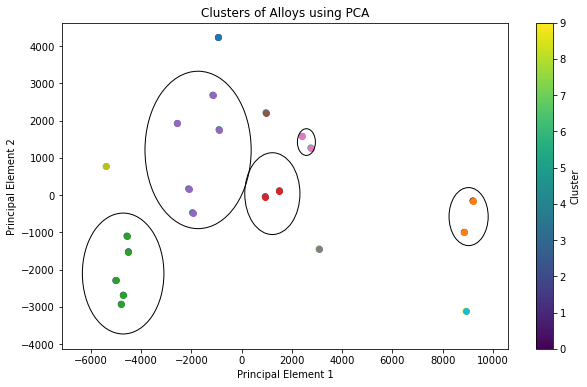

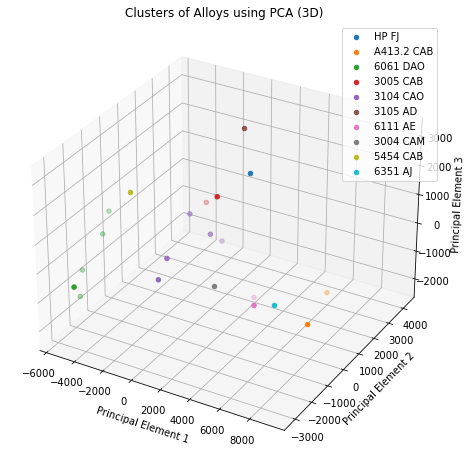

In [10]:
def create_clusters_with_pca(element):
  training, testing = prepare_datasets(element)
  X_train, y_train = zip(*training)
  X_test, y_test = zip(*testing)

  pca = PCA(n_components=9)
  X_pca = pca.fit_transform(np.concatenate((X_train, X_test)))  # Combine training and testing data

  kmeans = KMeans(n_clusters=10, random_state=42)
  kmeans.fit(X_pca)
  cluster_labels = kmeans.labels_

  # 2D plot
  plt.figure(figsize=(10, 6))
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
  plt.xlabel('Principal Element 1')
  plt.ylabel('Principal Element 2')
  plt.title('Clusters of Alloys using PCA')
  plt.colorbar(label='Cluster')

  for cluster_label in range(10):
    cluster_points = X_pca[cluster_labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')
    centroid = cluster_points.mean(axis=0)
    radius = max(np.linalg.norm(point - centroid) for point in cluster_points)  # Efficient distance calculation
    circle = plt.Circle(centroid, radius, color='black', fill=False)
    plt.gca().add_patch(circle)

  # 3D plot
  alloy_types = {0: 'HP FJ', 1: 'A413.2 CAB', 2: '6061 DAO', 3: '3005 CAB', 4: '3104 CAO',
                 5: '3105 AD', 6: '6111 AE', 7: '3004 CAM', 8: '5454 CAB', 9: '6351 AJ'}

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  for cluster_label in range(10):
    cluster_points = X_pca[cluster_labels == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=alloy_types[cluster_label])

  ax.set_xlabel('Principal Element 1')
  ax.set_ylabel('Principal Element 2')
  ax.set_zlabel('Principal Element 3')
  ax.set_title('Clusters of Alloys using PCA (3D)')
  ax.legend()

  plt.show()

# Clusters for 'Cu' for example
create_clusters_with_pca('Cu')


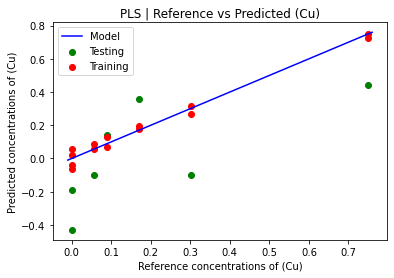

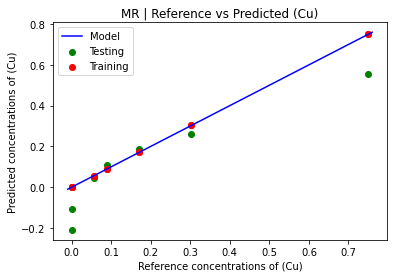

---

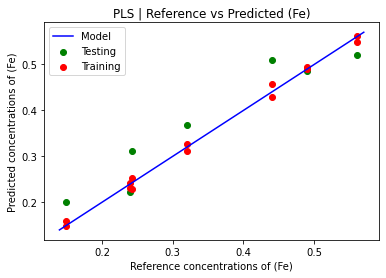

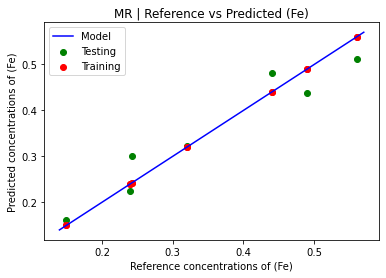

---

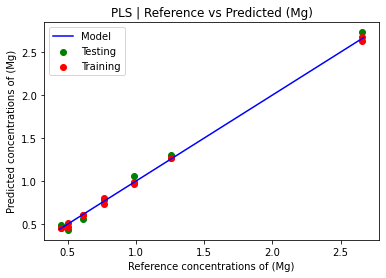

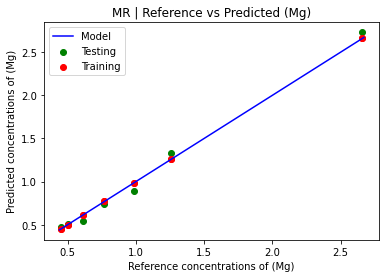

---

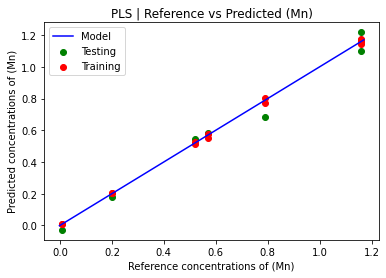

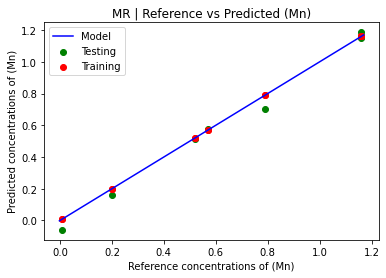

---

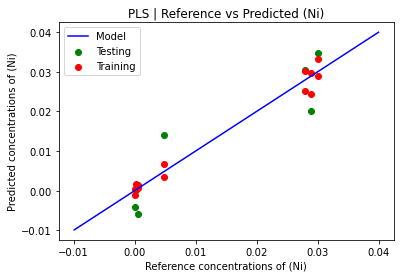

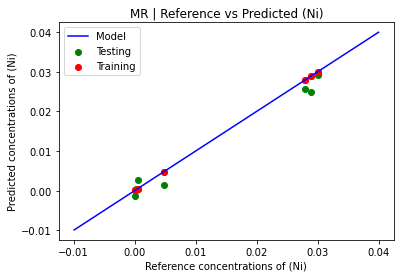

---

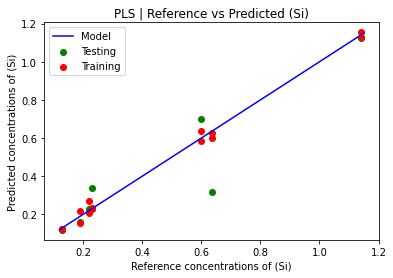

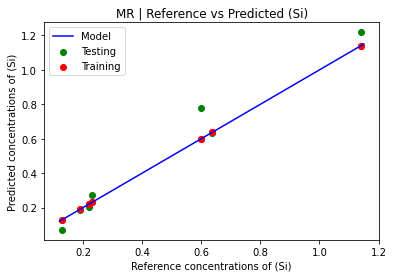

---

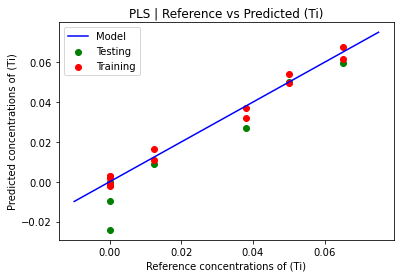

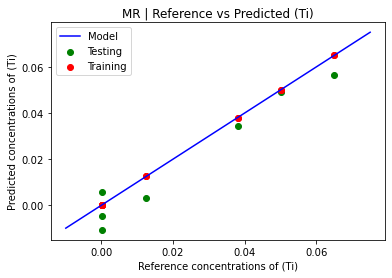

---

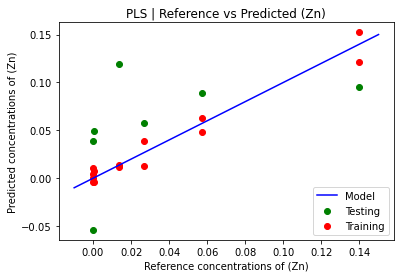

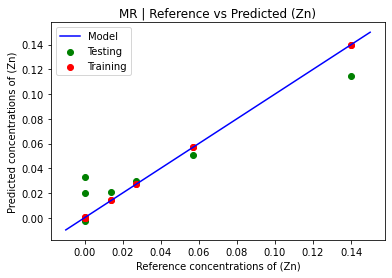

---

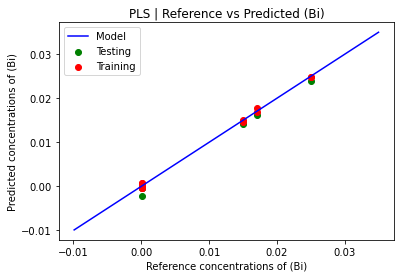

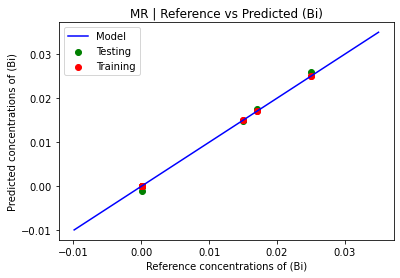

---

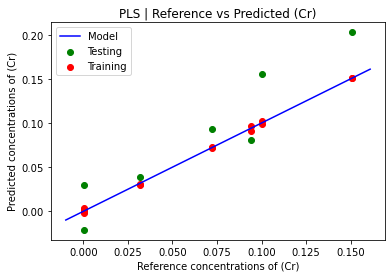

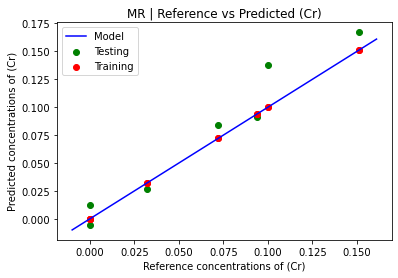

---

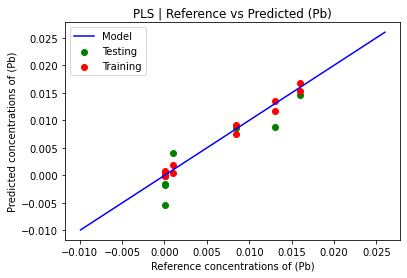

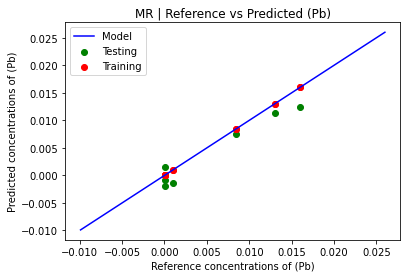

---

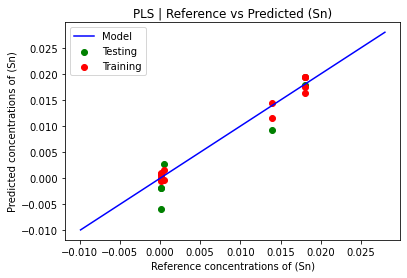

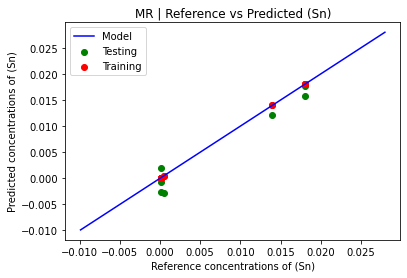

---

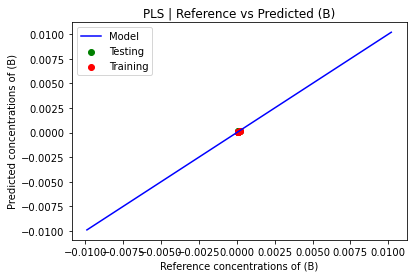

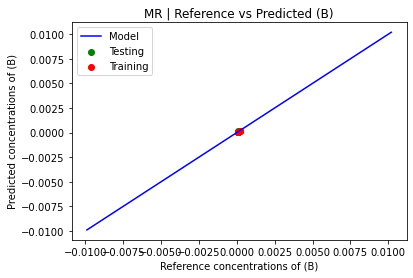

---

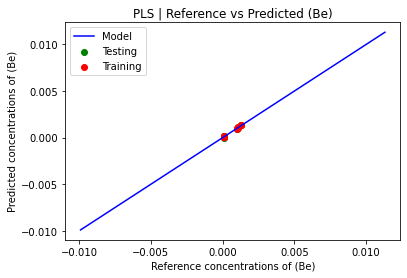

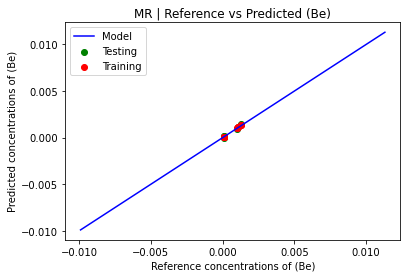

---

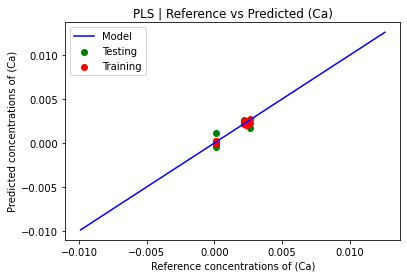

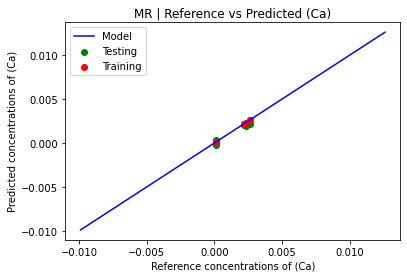

---

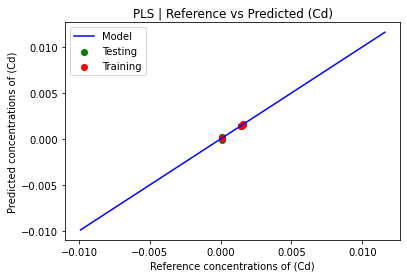

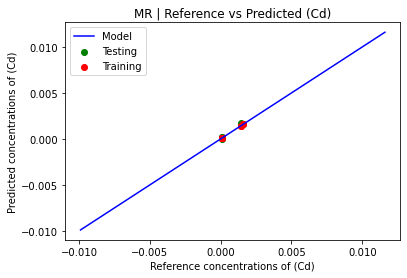

---

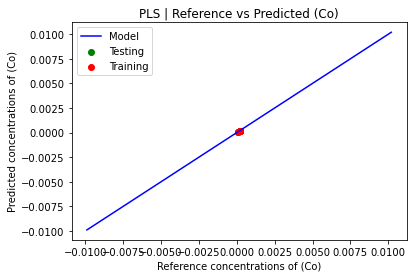

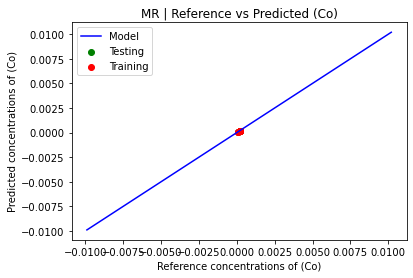

---

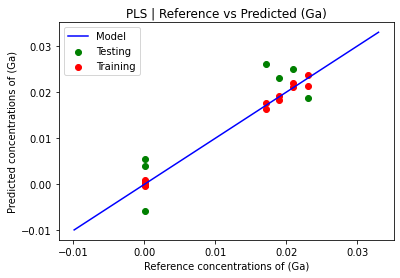

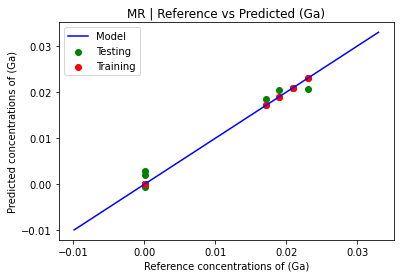

---

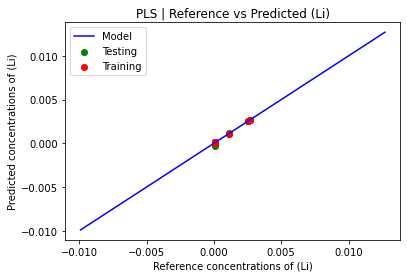

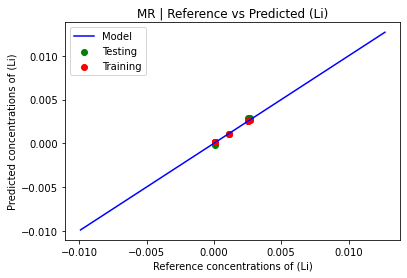

---

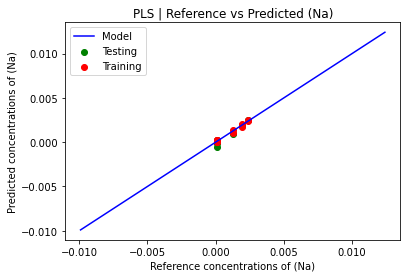

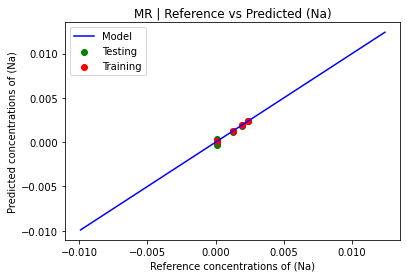

---

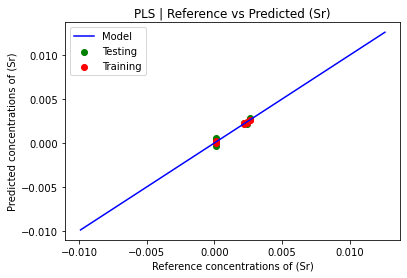

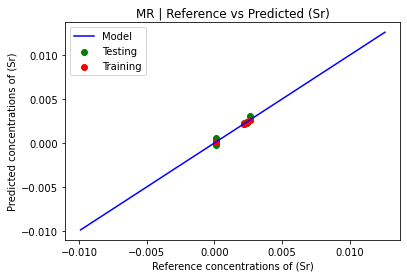

---

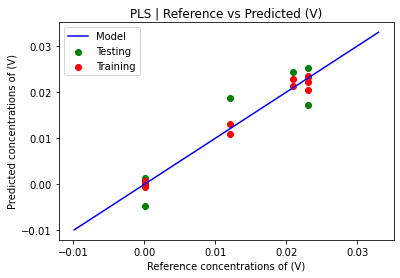

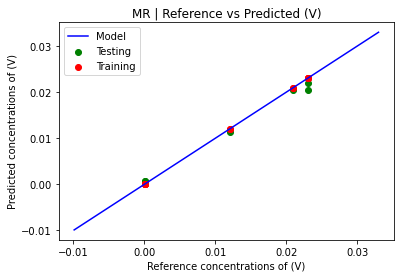

---

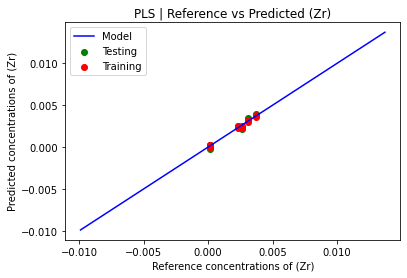

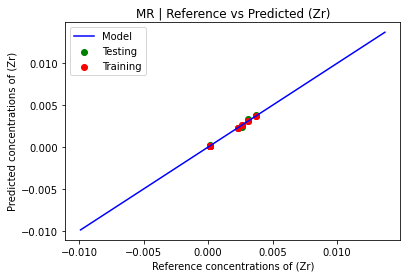

---

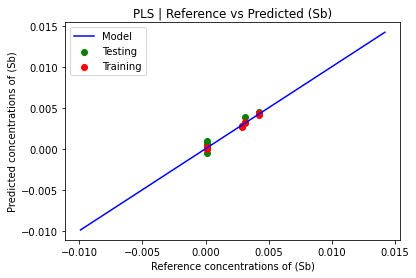

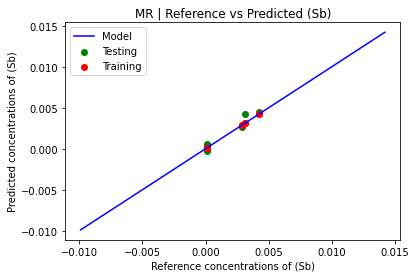

---

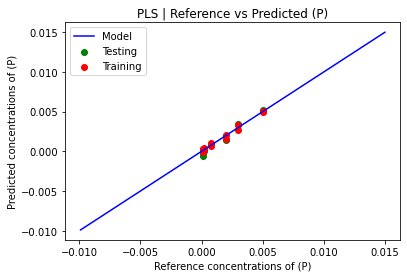

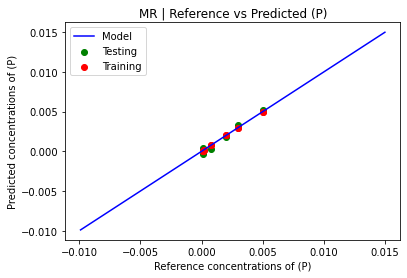

---

 Element   |  R2 (PLS)  | RMSE (PLS) |  R2 (MR)   | RMSE (MR) 
    Cu     |   -0.28    |  2.79e-01  |    0.77    |  1.18e-01 
    Fe     |    0.88    |  4.87e-02  |    0.92    |  3.88e-02 
    Mg     |    0.99    |  5.46e-02  |    0.99    |  5.81e-02 
    Mn     |    0.98    |  5.56e-02  |    0.99    |  4.50e-02 
    Ni     |    0.81    |  6.02e-03  |    0.97    |  2.39e-03 
    Si     |    0.85    |  1.33e-01  |    0.95    |  7.83e-02 
    Ti     |    0.80    |  1.11e-02  |    0.92    |  7.04e-03 
    Zn     |   -0.39    |  5.58e-02  |    0.86    |  1.77e-02 
    Bi     |    0.98    |  1.22e-03  |    1.00    |  6.96e-04 
    Cr     |    0.59    |  3.33e-02  |    0.89    |  1.72e-02 
    Pb     |    0.77    |  3.07e-03  |    0.90    |  2.06e-03 
    Sn     |    0.84    |  3.25e-03  |    0.94    |  2.07e-03 
    B      |    0.94    |  1.10e-05  |    0.99    |  5.18e-06 
    Be     |    0.98    |  7.23e-05  |    0.97    |  9.15e-05 
    Ca     |    0.71    |  6.03e-04  |    0.95    |  2.

In [11]:
def create_model(model, element, model_code, plot_model=False, threshold=0.5):
  try:
    if not model:
      return None, None, None

    training, testing = prepare_datasets(element)
    X_train, y_train = zip(*training)
    X_test, y_test = zip(*testing)
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    if plot_model:
      plt.scatter(y_test, model.predict(X_test), color='g', label="Testing")
      plt.scatter(y_train, model.predict(X_train), color='r', label="Training")
      plt.xlabel(f"Reference concentrations of ({element})")
      plt.ylabel(f"Predicted concentrations of ({element})")
      plt.title(f"{model_code} | Reference vs Predicted ({element})")
      plt.plot([min(y_train) - 0.01, max(y_train) + 0.01], [min(y_train) - 0.01, max(y_train) + 0.01], color='b', label="Model")
      plt.legend()
      plt.show()

    return model, r2, rmse

  except Exception as e:
    print(f"EXCEPTION: create_model({element}) : {e}")
    return None, None, None

# Testing models
scores = {}
for element in ELEMENTS:
  pls_model, pls_r2, pls_rmse = create_model(PLSRegression(n_components=7), element, "PLS", True)
  mr_model, mr_r2, mr_rmse = create_model(linear_model.LinearRegression(), element, "MR", True)
  scores[element] = {'pls': {'r2': pls_r2, 'rmse': pls_rmse}, 'mr': {'r2': mr_r2, 'rmse': mr_rmse}}
  display(Markdown('---'))


print("{:^10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Element", "R2 (PLS)", "RMSE (PLS)", "R2 (MR)", "RMSE (MR)"))
for element, data in scores.items():
  pls_r2, pls_rmse = data['pls'].values()
  mr_r2, mr_rmse = data['mr'].values()
  print("{:^10} | {:^10.2f} | {:^10.2e} | {:^10.2f} | {:^10.2e}".format(element, pls_r2, pls_rmse, mr_r2, mr_rmse))
